In [26]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
import sys
from tqdm import tqdm
import torch

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
# from new_pokie import pokie, pokie_bootstrap
from pokie import pokie, pokie_bootstrap, get_device, pokie_with_convergence_estimate

# Sample from GMM

In [27]:
def generate_samples_from_gmm(means, covariances, n_samples):
    """
    means:       shape (n_components, n_dimensions)
    covariances: shape (n_components, n_dimensions),
                 each row is the diagonal of the covariance matrix for that component
    n_samples:   number of samples to generate in total
    """
    n_components, n_dimensions = means.shape
    samples = np.zeros((n_samples, n_dimensions))
    # Assume uniform mixing weights for simplicity
    component_choices = np.random.choice(
        n_components, size=n_samples, p=np.ones(n_components)/n_components
    )

    for i, comp in enumerate(component_choices):
        # Use np.diag(...) so each component's covariance is diagonal
        cov = np.diag(covariances[comp])
        samples[i, :] = np.random.multivariate_normal(means[comp], cov)
    return samples

# 2 Dimension

In [28]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 2
n_truth_samples = 1000  # Number of ground truth samples
num_posterior_samples = 1000  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 40.62it/s]


In [29]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 113.20it/s]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.0425155  0.04366847 0.04442467 0.04558301 0.04690564 0.04794638
 0.0494993  0.05097362 0.05215738 0.05310996 0.05333388 0.0525982
 0.05157804 0.05022326 0.04900465 0.0473363  0.04608856 0.04464212
 0.0437649  0.04275957 0.04188654]
Calibrated: [0.53273165 0.5471788  0.55665416 0.5711685  0.5877415  0.6007822
 0.6202407  0.63871443 0.65354735 0.6654834  0.6682892  0.6590709
 0.6462881  0.6293122  0.61404264 0.5931378  0.5775032  0.55937886
 0.54838705 0.53578997 0.52485067]


# 2D GMM Plots

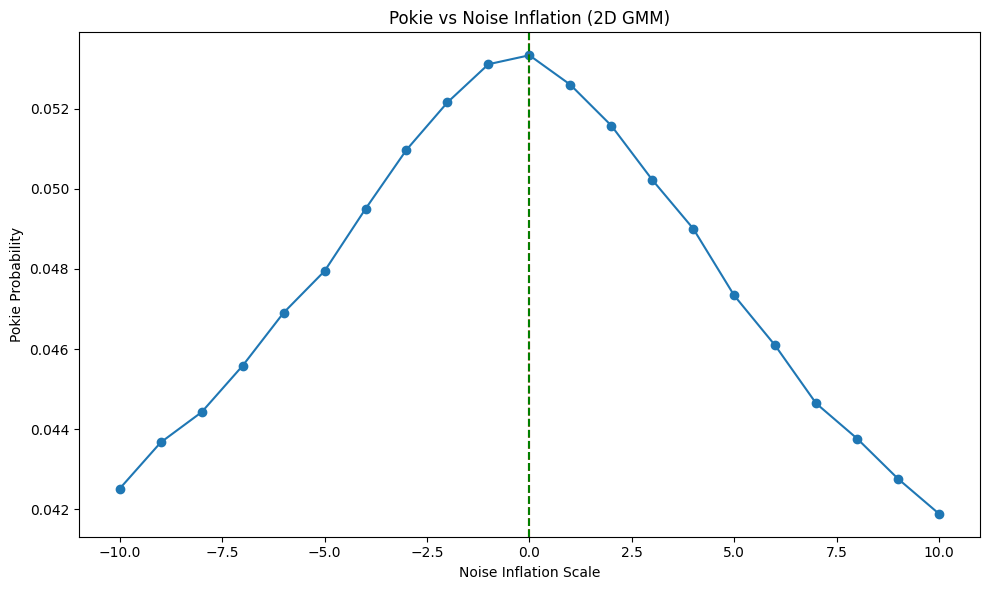

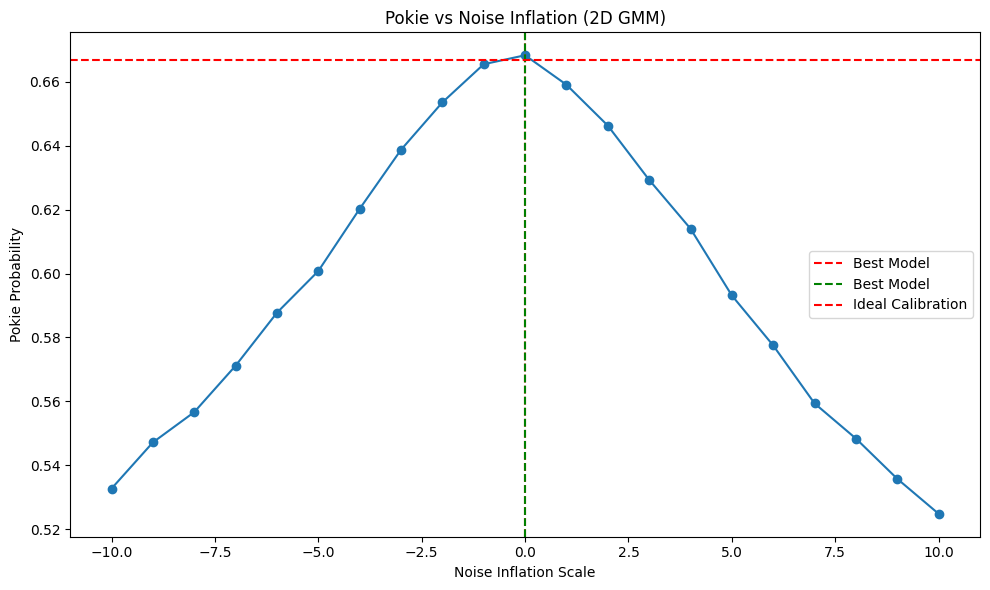

In [30]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (2D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_2D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (2D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_2D_GMM_Calibrated.pdf")
plt.show()

# 2 Dimensional n/N Distribution Plots

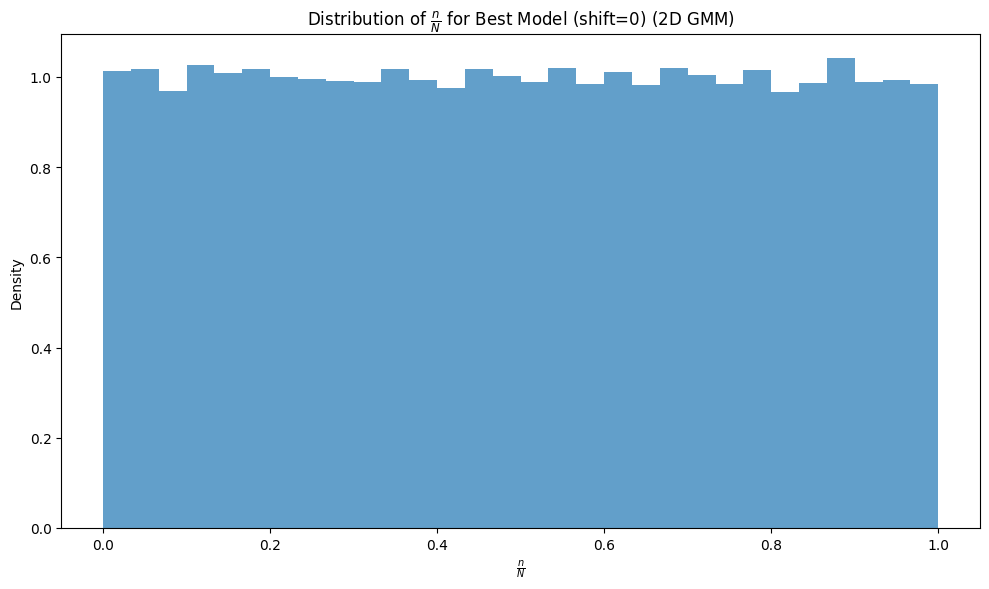

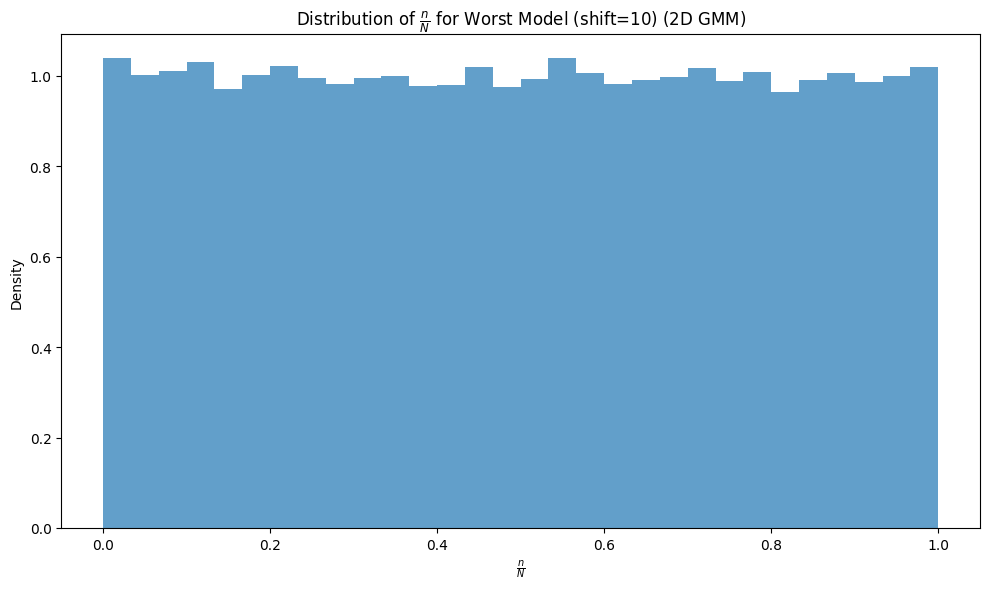

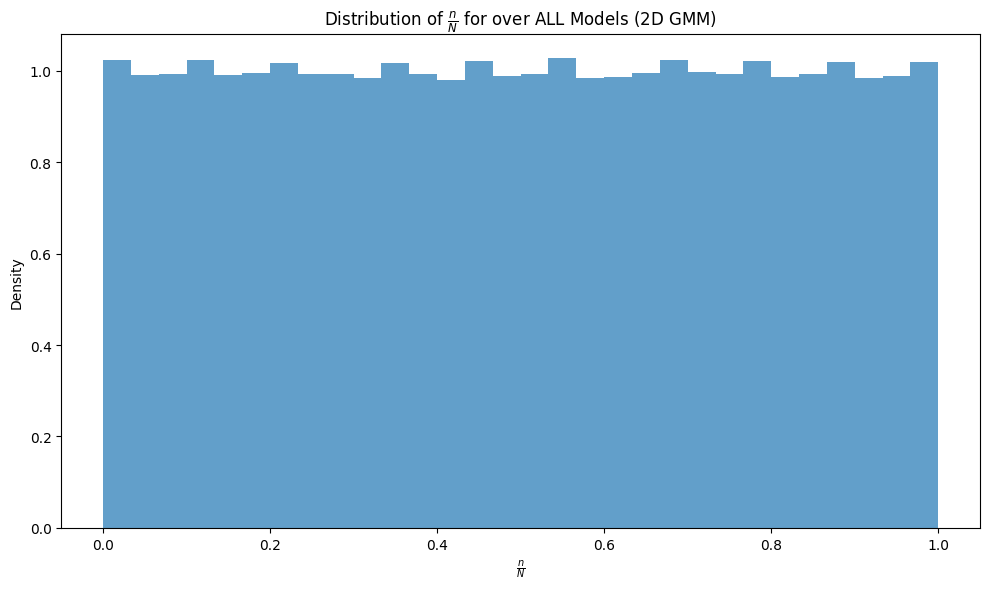

In [31]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_Best_Model_n_over_N_2D_GMM.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_Worst_Model_n_over_N_2D_GMM.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_n_over_N_2D_GMM.pdf")
plt.show()

# 2D Convergence Test & Plots

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:01<00:00, 85.21it/s]


\Modes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
Emperical Pokie: [0.04236724 0.04361406 0.04446256 0.04562895 0.04682133 0.04797123
 0.04955519 0.050902   0.05222614 0.05310965 0.053202   0.05259236
 0.05164051 0.05028849 0.049031   0.04741104 0.04602408 0.04471688
 0.04373268 0.04275398 0.04194859]
Theoretical Pokie: [0.6670588  0.66646016 0.6668734  0.6670306  0.6667341  0.6665384
 0.6676098  0.666942   0.6670054  0.6666426  0.6661951  0.6666456
 0.66652095 0.667228   0.66747755 0.6663961  0.6660424  0.6658891
 0.6663116  0.6664013  0.6660658 ]
Convergence Gap: [ 0.13616174  0.11993939  0.10972029  0.09526157  0.08002359  0.06541872
  0.04664177  0.02909732  0.01256812  0.00113416 -0.00047058  0.0076192
  0.01942205  0.03707099  0.053078    0.07229596  0.08932203  0.10554916
  0.11830449  0.13065815  0.14041483]


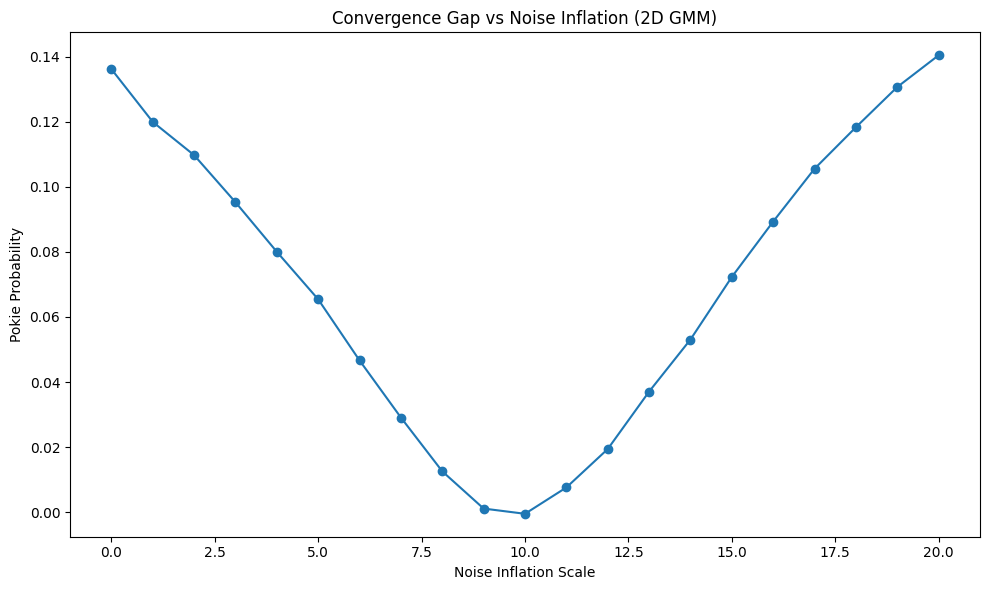

E[lambda]: 0.5005573630332947
E[lambda^2]: 0.33382123708724976


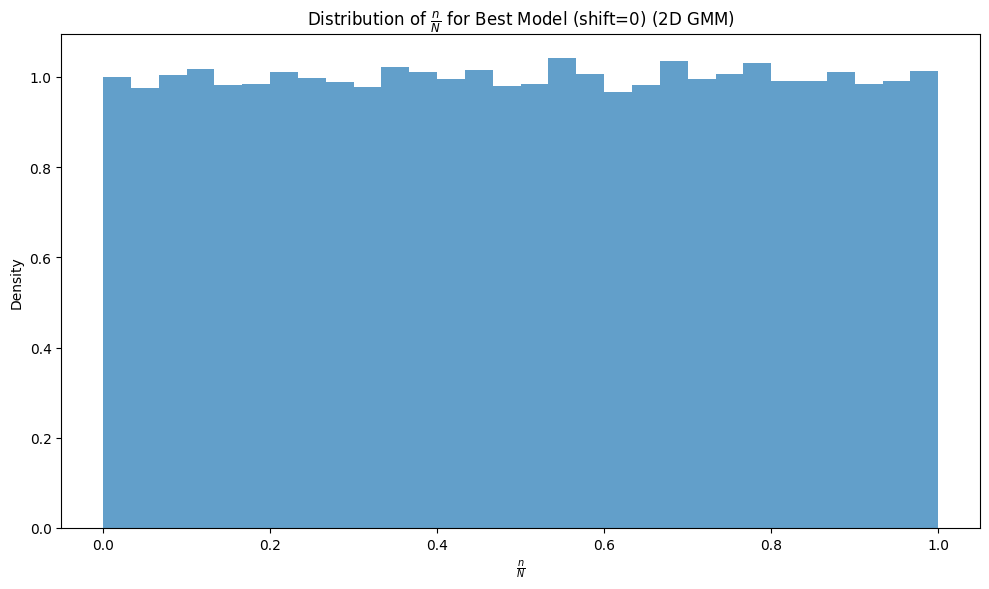

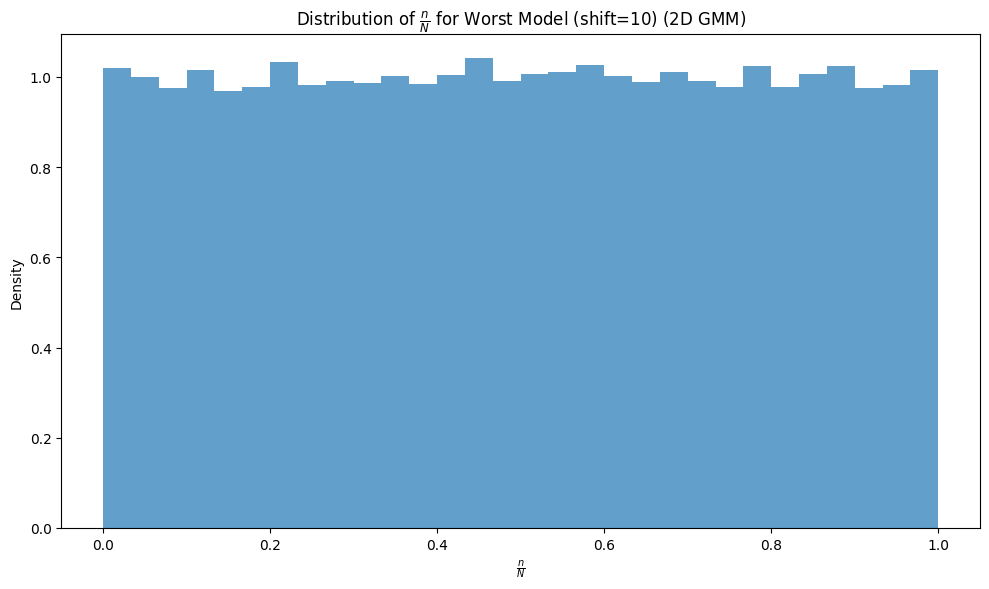

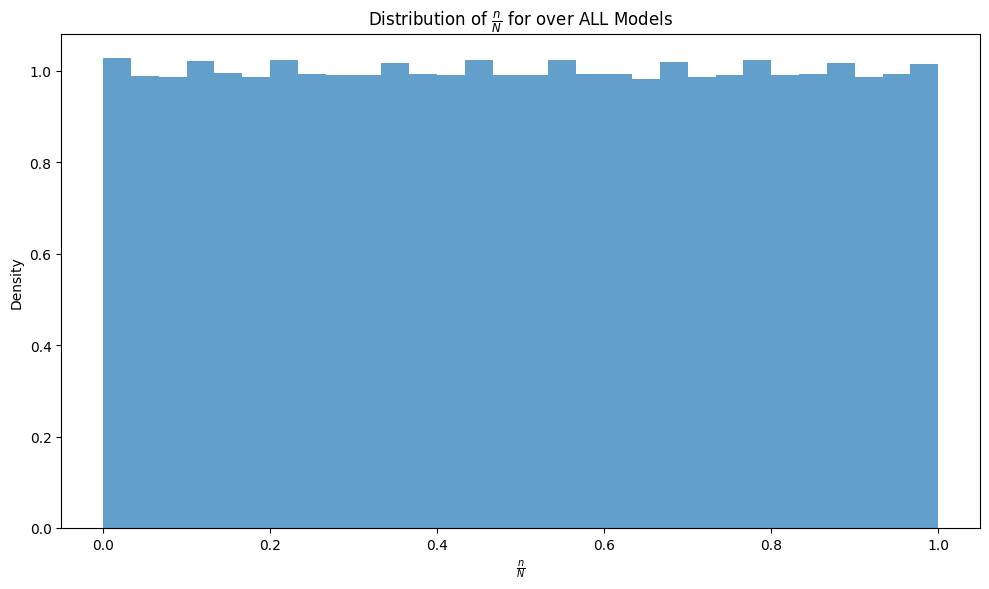

In [32]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

out = pokie_with_convergence_estimate(truth_data_normalized, models_normalized, num_runs = 100)

l_values = np.linspace(0, len(results) - 1, len(results))
l_values = np.array(l_values)

emperical_pokie = out['empirical_pokie'].cpu().numpy()
theoretical_pokie = out['theoretical_pokie'].cpu().numpy()
convergence_gap = out['convergence_gap'].cpu().numpy()
E_lambda = out['E_lambda'].cpu().numpy()
E_lambda_sq = out['E_lambda_sq'].cpu().numpy()
n_over_N_vals = out['n_over_N_vals'].cpu().numpy()

print('\Modes:', l_values)
print('Emperical Pokie:', emperical_pokie)
print('Theoretical Pokie:', theoretical_pokie)
print('Convergence Gap:', convergence_gap)

plt.figure(figsize=(10, 6))
plt.plot(l_values, convergence_gap, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Convergence Gap vs Noise Inflation (2D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_Convergence_Gap_2D_GMM.pdf")
plt.show()

# Identify the best model
best_model_idx = np.argmin(convergence_gap)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

print("E[lambda]:", out["E_lambda"][best_model_idx].item())
print("E[lambda^2]:", out["E_lambda_sq"][best_model_idx].item())

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_Convergence_Best_Model_n_over_N_Lensed_Images.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmax(convergence_gap)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_Convergence_Worst_Model_n_over_N_Lensed_Images.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_Convergence_n_over_N_Lensed_Images.pdf")
plt.show()

# 20 Dimensions

In [33]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 10
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 65.76it/s]


In [34]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 152.68it/s]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04254326 0.04247751 0.04261864 0.04316469 0.04402817 0.0462571
 0.04921548 0.05225187 0.05504714 0.05645365 0.05673079 0.05635069
 0.05443686 0.05124512 0.04762079 0.04517604 0.04347166 0.04281794
 0.04275146 0.04273248 0.04260865]
Calibrated: [0.50055015 0.49977654 0.50143707 0.5078616  0.5180211  0.54424596
 0.5790533  0.61477846 0.64766675 0.66421527 0.6674761  0.663004
 0.64048636 0.60293335 0.5602907  0.5315266  0.5114735  0.5037819
 0.5029997  0.5027764  0.5013195 ]


# 20D GMM Plots

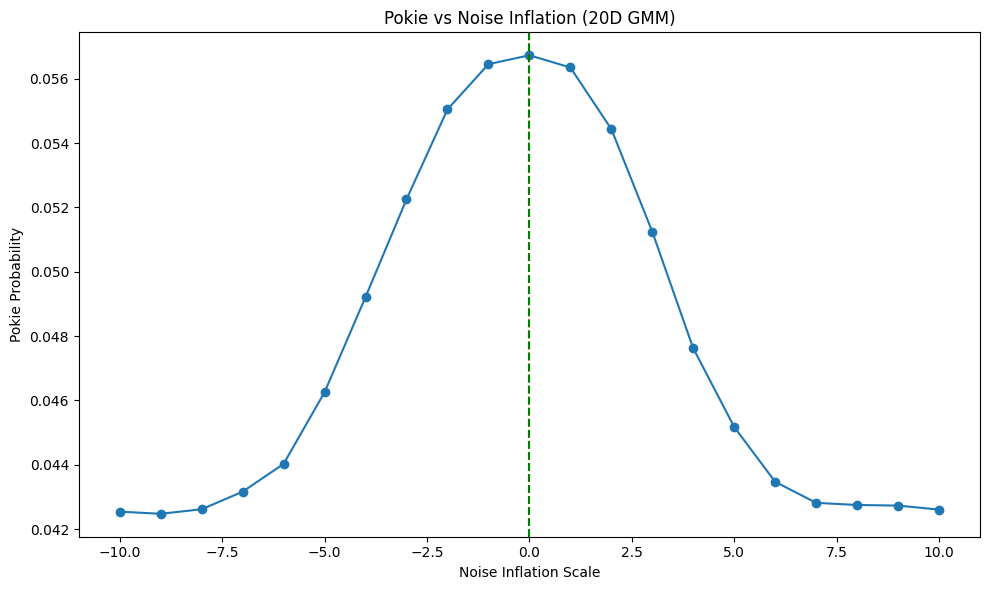

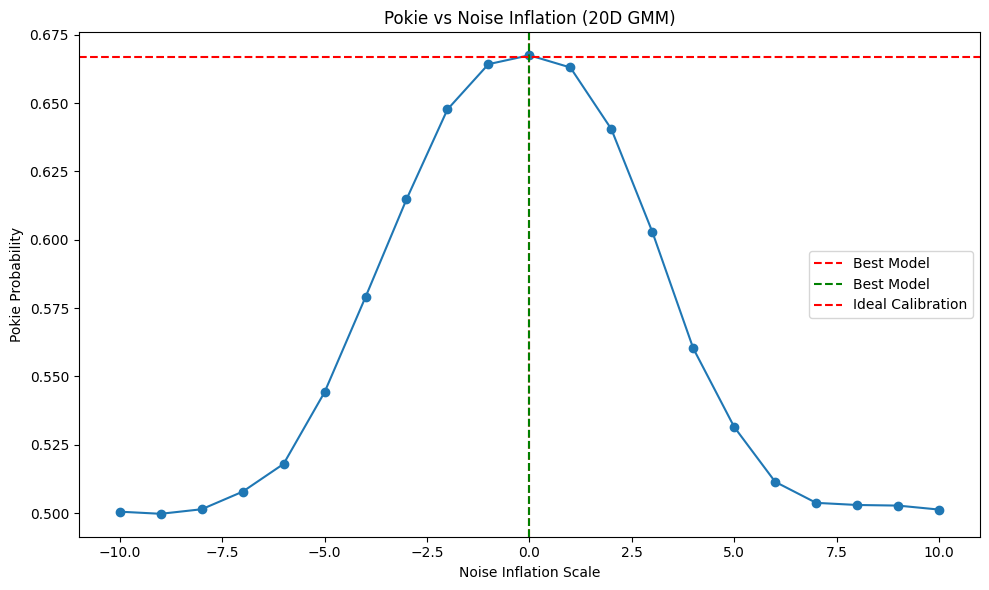

In [35]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (20D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_20D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (20D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_20D_GMM_Calibrated.pdf")
plt.show()

# 20 Dimensional n/N Distribution Plots

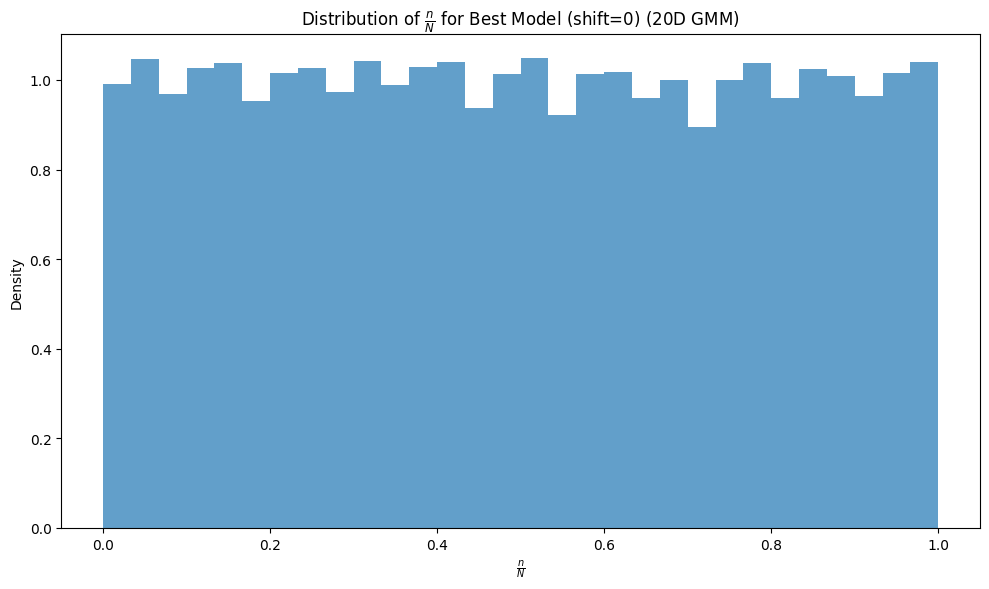

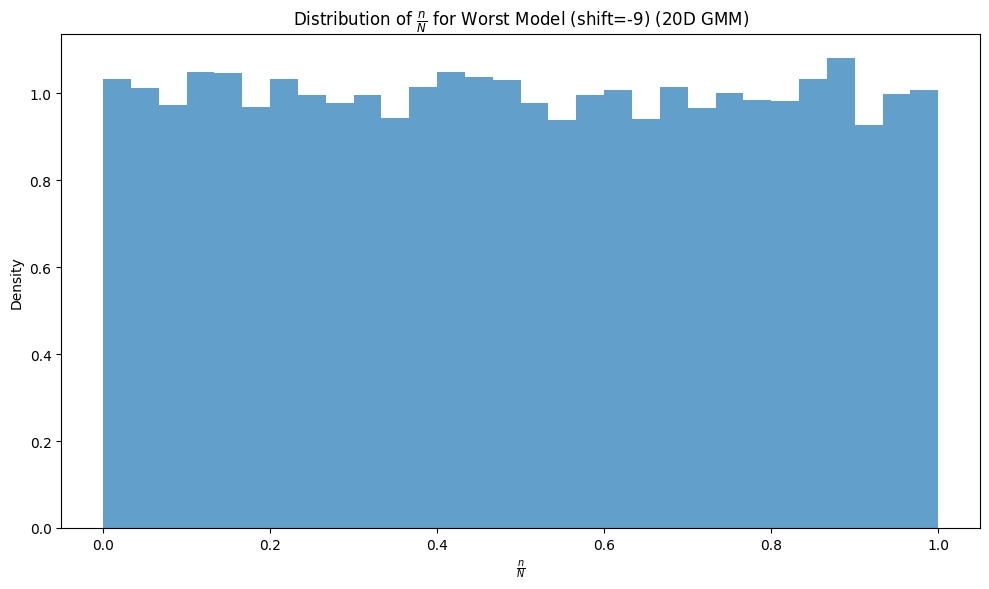

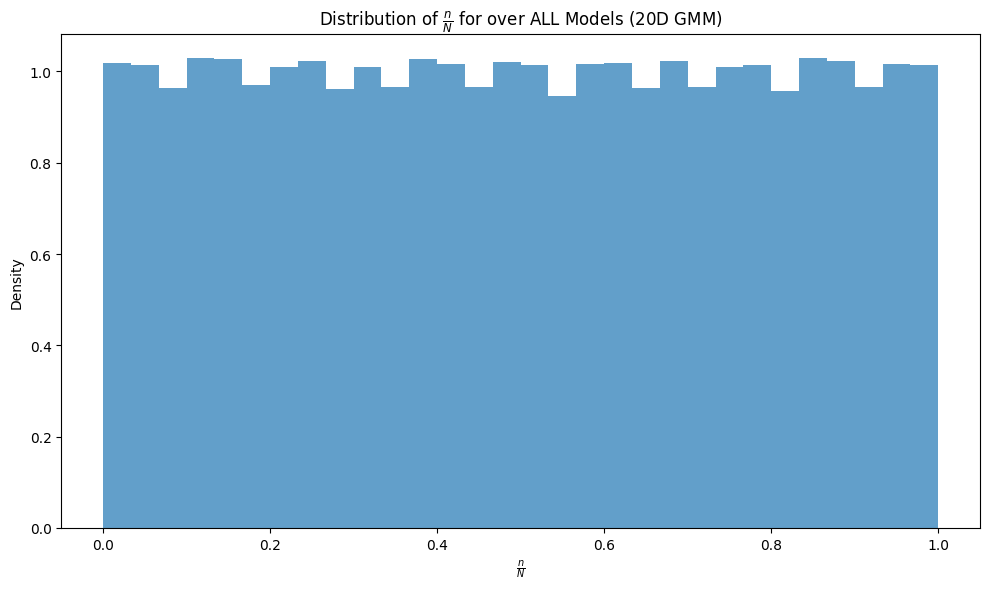

In [36]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_Best_Model_n_over_N_20D_GMM.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_Worst_Model_n_over_N_20D_GMM.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_n_over_N_20D_GMM.pdf")
plt.show()

# 20D Convergence Test & Plots

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:01<00:00, 99.48it/s] 


\Modes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
Emperical Pokie: [0.04257251 0.04258523 0.0425141  0.04326897 0.04407122 0.04636255
 0.04938149 0.05230041 0.0549446  0.05617745 0.0566366  0.05628977
 0.05455488 0.05124592 0.04795935 0.04509889 0.04364754 0.04293887
 0.04256437 0.04251388 0.04237135]
Theoretical Pokie: [0.6663801  0.66578865 0.6672128  0.6661354  0.66697794 0.667199
 0.6652855  0.66649306 0.6666848  0.6663358  0.66563624 0.666251
 0.66617286 0.6664471  0.6655206  0.66727483 0.6658376  0.6672651
 0.6670831  0.6671082  0.6666729 ]
Convergence Gap: [ 0.16539967  0.1646586   0.16691965  0.15695912  0.1483612   0.12161845
  0.08417898  0.05103761  0.02011329  0.00525659 -0.00084615  0.00385004
  0.02418756  0.06340051  0.1011495   0.13656467  0.15220648  0.16197348
  0.16619855  0.16681772  0.16805962]


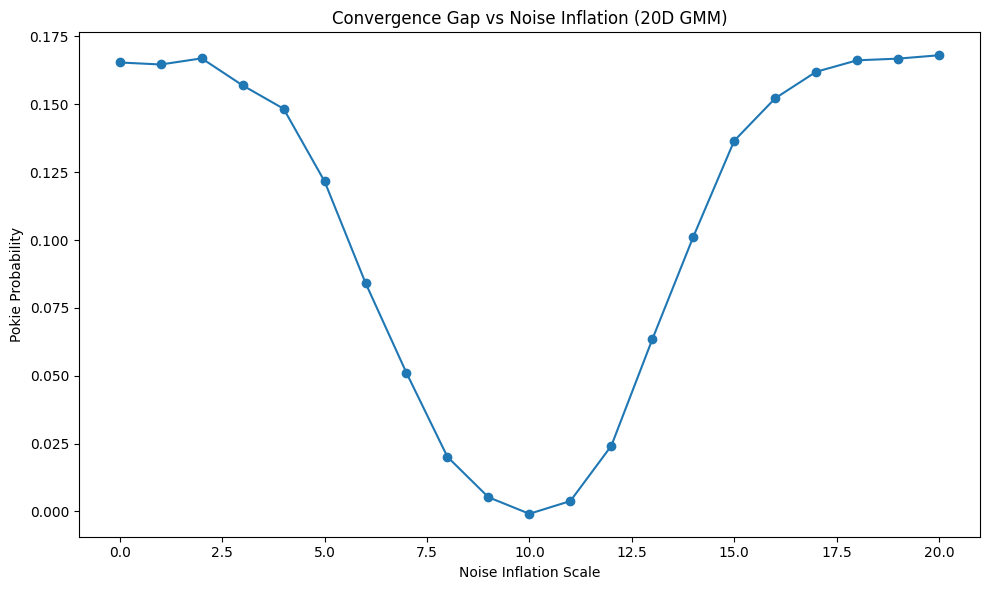

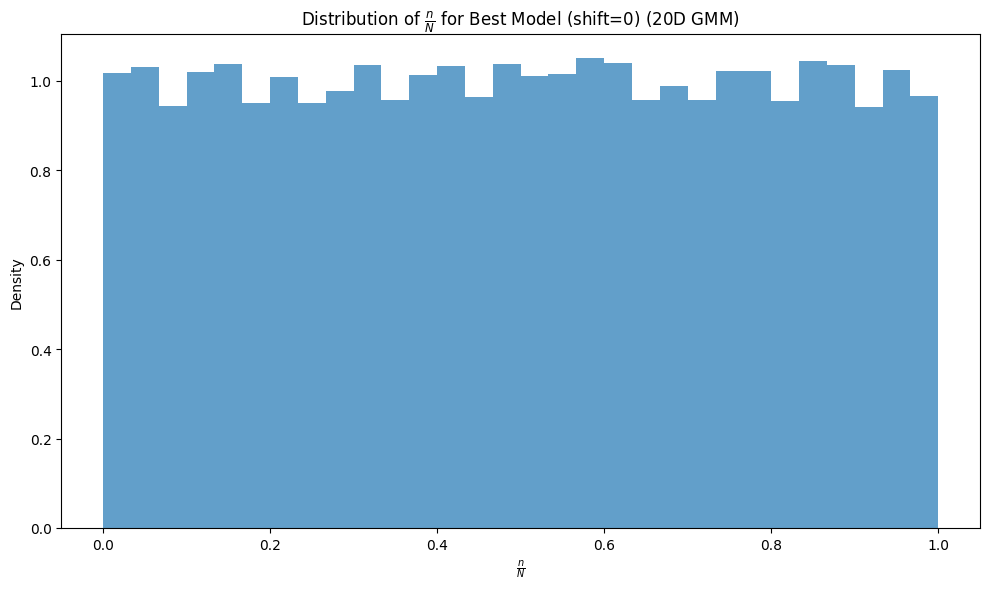

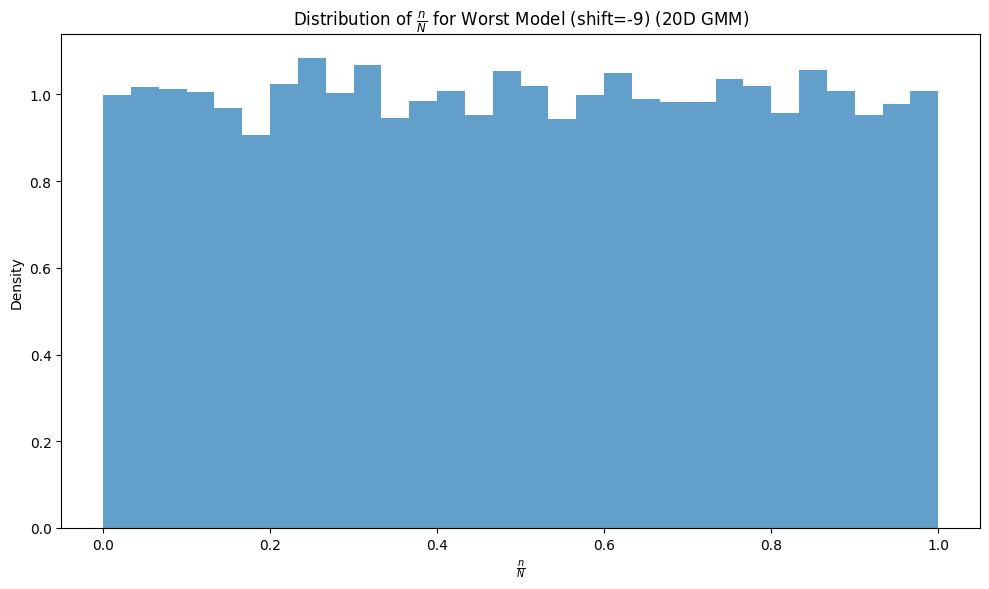

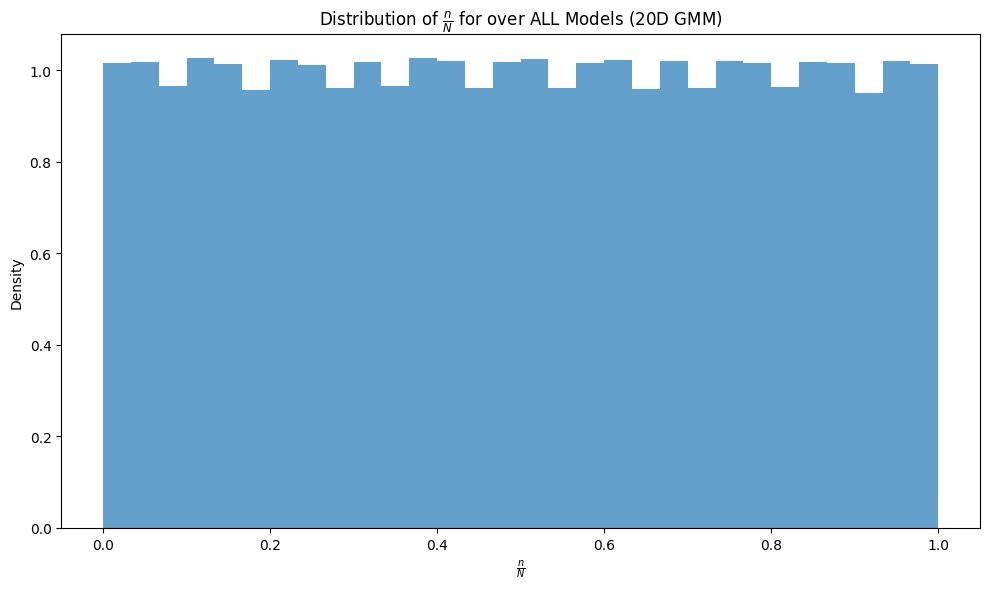

In [37]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

out = pokie_with_convergence_estimate(truth_data_normalized, models_normalized, num_runs = 100)

l_values = np.linspace(0, len(results) - 1, len(results))
l_values = np.array(l_values)

emperical_pokie = out['empirical_pokie'].cpu().numpy()
theoretical_pokie = out['theoretical_pokie'].cpu().numpy()
convergence_gap = out['convergence_gap'].cpu().numpy()
E_lambda = out['E_lambda'].cpu().numpy()
E_lambda_sq = out['E_lambda_sq'].cpu().numpy()
n_over_N_vals = out['n_over_N_vals'].cpu().numpy()

print('\Modes:', l_values)
print('Emperical Pokie:', emperical_pokie)
print('Theoretical Pokie:', theoretical_pokie)
print('Convergence Gap:', convergence_gap)

plt.figure(figsize=(10, 6))
plt.plot(l_values, convergence_gap, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Convergence Gap vs Noise Inflation (20D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_Convergence_Gap_20D_GMM.pdf")
plt.show()

# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_Best_Model_n_over_N_20D_GMM.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_Worst_Model_n_over_N_20D_GMM.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_Convergence_n_over_N_20D_GMM.pdf")
plt.show()

# 100 Dimension

In [38]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 100
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


In [39]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [16:09<00:00,  9.70s/it]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04502238 0.04506316 0.04488713 0.04509778 0.04465481 0.04496405
 0.04459312 0.04569123 0.05139912 0.05823968 0.05969152 0.05870441
 0.05204426 0.04579449 0.04496631 0.04499623 0.04495066 0.04493915
 0.04469569 0.04470733 0.04489737]
Calibrated: [0.50306845 0.5035242  0.5015573  0.50391096 0.49896133 0.5024167
 0.4982721  0.5105421  0.5743205  0.65075517 0.6669775  0.65594786
 0.58152914 0.5116959  0.502442   0.50277627 0.5022671  0.5021384
 0.49941814 0.4995482  0.50167173]


# 100D GMM Plots

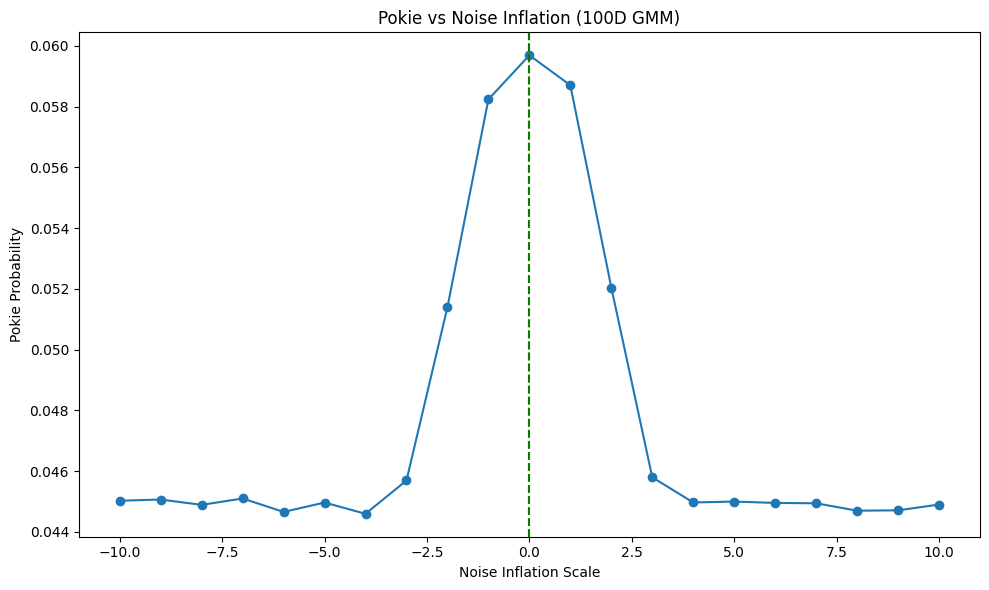

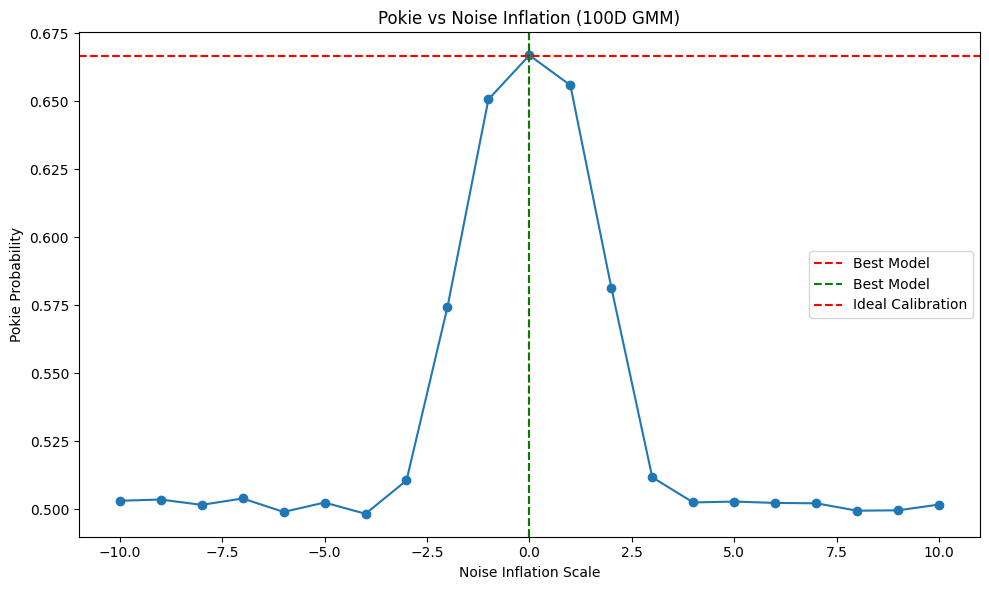

In [40]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (100D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_100D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (100D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_100D_GMM_Calibrated.pdf")
plt.show()

# 100 Dimensional n/N Distribution Plots

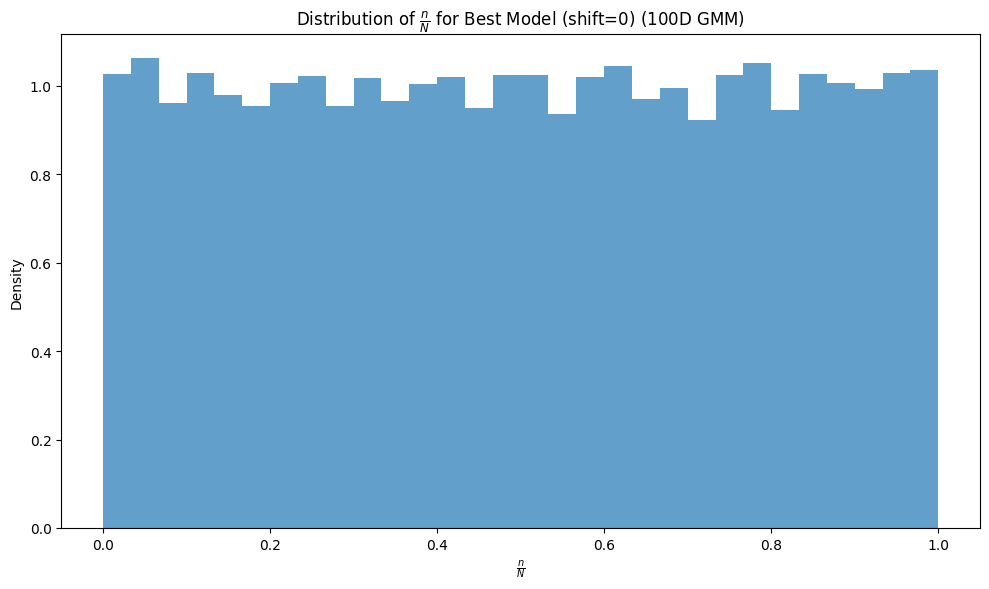

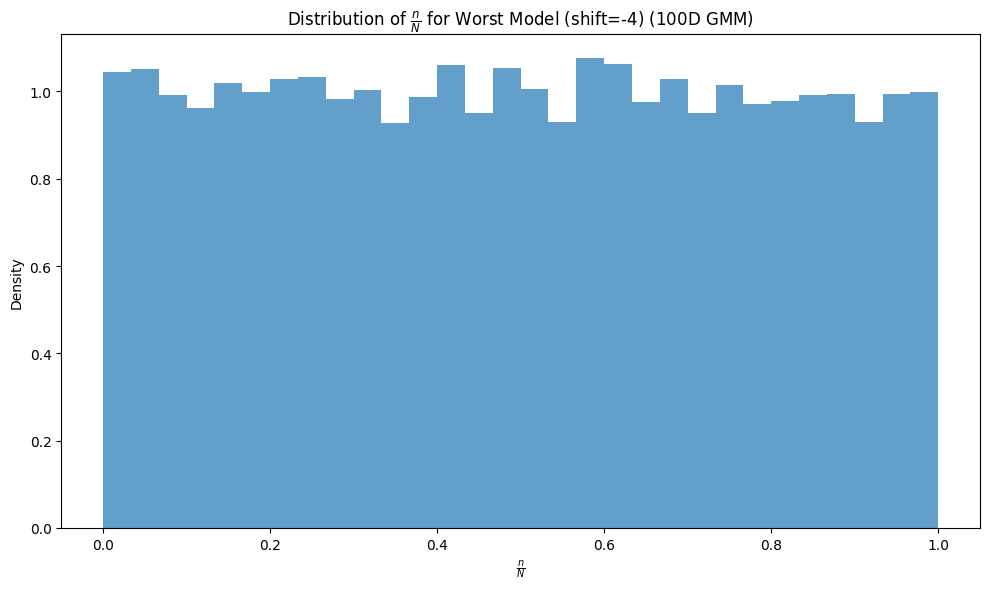

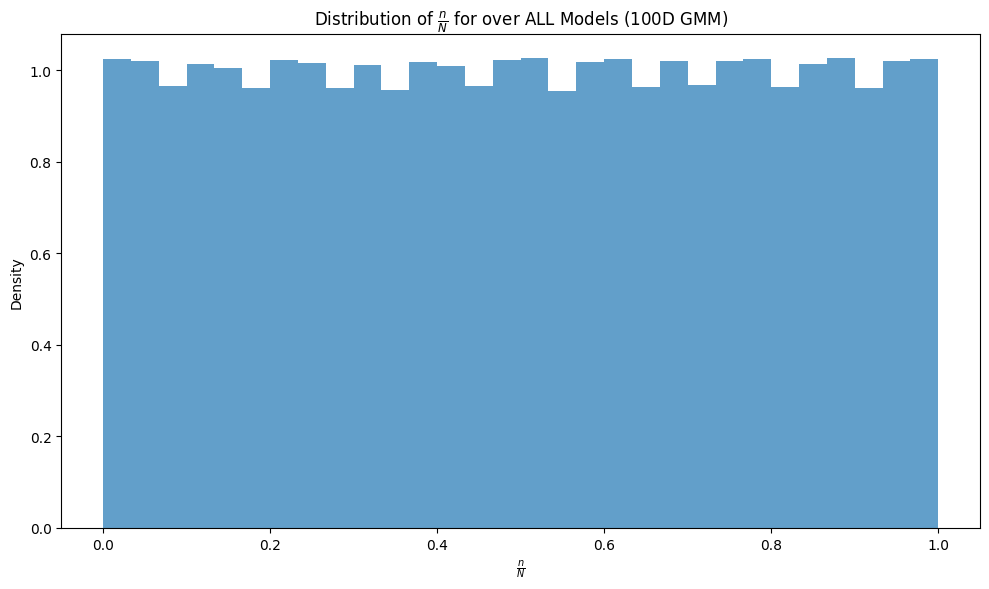

In [41]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_Best_Model_n_over_N_100D_GMM.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_Worst_Model_n_over_N_100D_GMM.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_n_over_N_100D_GMM.pdf")
plt.show()

# 100D Convergence Test & Plots

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [17:48<00:00, 10.68s/it]


\Modes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
Emperical Pokie: [0.04490599 0.04492489 0.04489283 0.04502844 0.0449205  0.04499738
 0.04487281 0.04550456 0.05142435 0.05853902 0.05970817 0.05880431
 0.05189921 0.04562878 0.04471367 0.04478366 0.04498348 0.04493903
 0.04472399 0.04493938 0.04486559]
Theoretical Pokie: [0.66694283 0.6666605  0.6671281  0.6682418  0.6666969  0.6664052
 0.6661318  0.6678001  0.6671965  0.6672749  0.66679114 0.6670122
 0.6658944  0.6661348  0.6679211  0.66728264 0.66686946 0.6664545
 0.665625   0.6665481  0.6674076 ]
Convergence Gap: [1.6546798e-01 1.6497457e-01 1.6580027e-01 1.6539961e-01 1.6506004e-01
 1.6390979e-01 1.6502750e-01 1.5964097e-01 9.2929780e-02 1.3557076e-02
 1.7225742e-05 1.0331988e-02 8.6324751e-02 1.5658844e-01 1.6859397e-01
 1.6717392e-01 1.6452926e-01 1.6461074e-01 1.6618261e-01 1.6470027e-01
 1.6638392e-01]


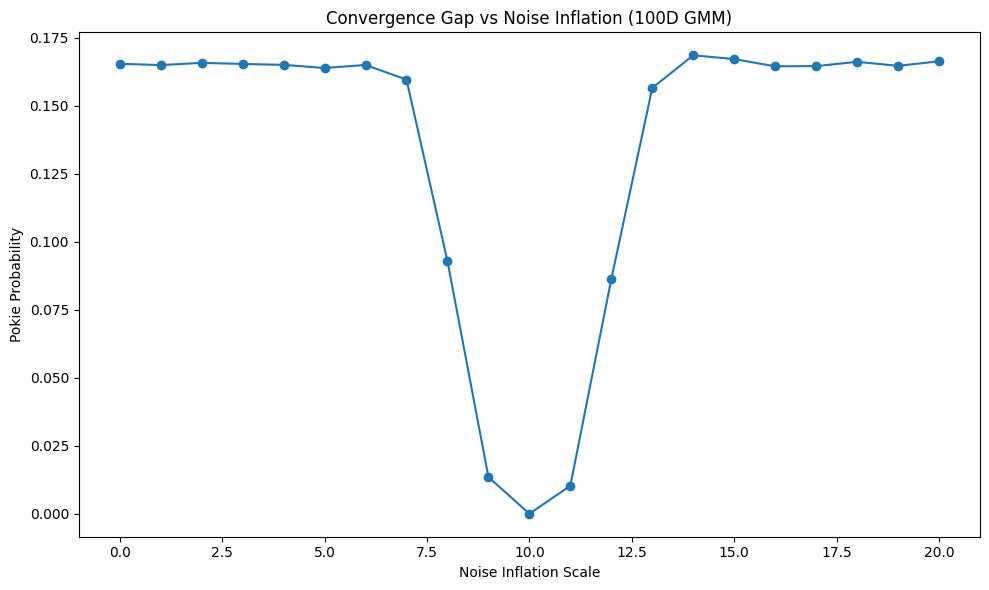

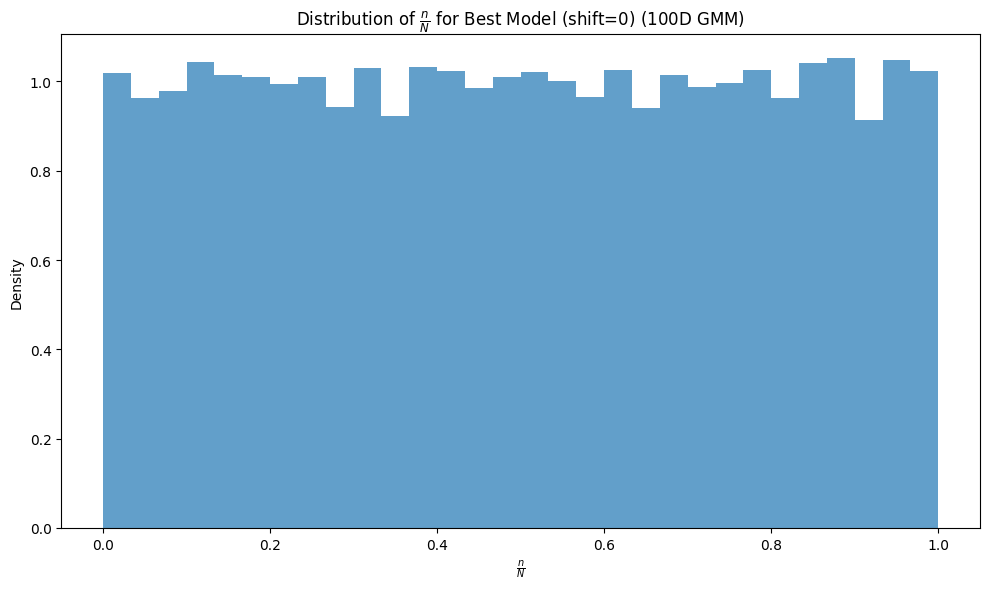

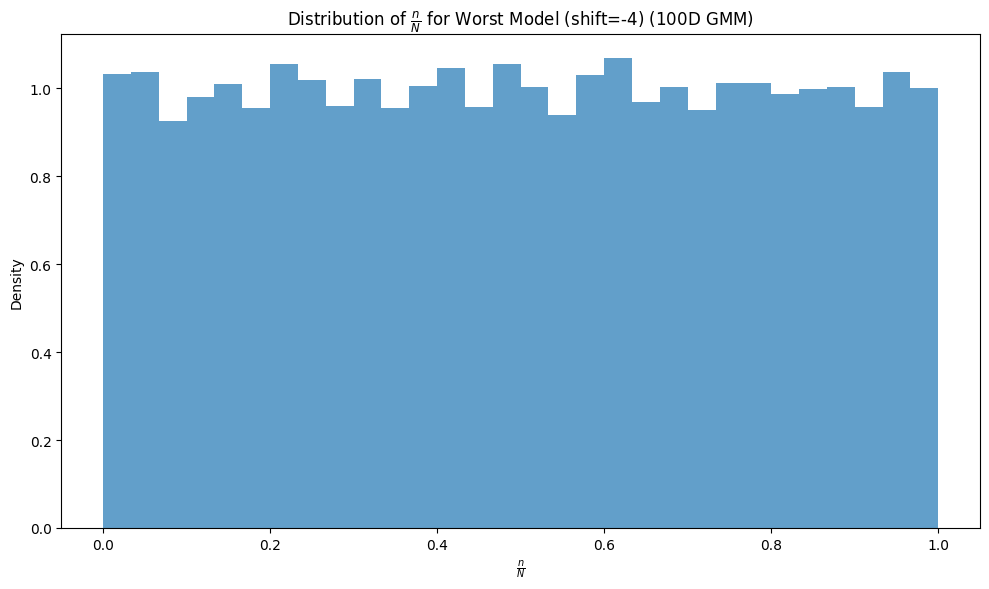

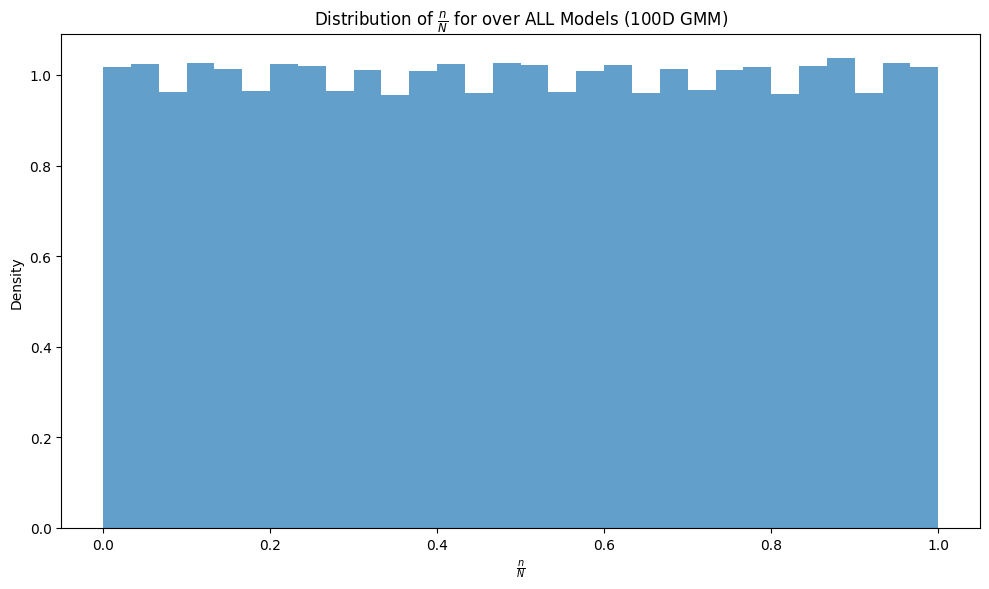

In [42]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

out = pokie_with_convergence_estimate(truth_data_normalized, models_normalized, num_runs = 100)

l_values = np.linspace(0, len(results) - 1, len(results))
l_values = np.array(l_values)

emperical_pokie = out['empirical_pokie'].cpu().numpy()
theoretical_pokie = out['theoretical_pokie'].cpu().numpy()
convergence_gap = out['convergence_gap'].cpu().numpy()
E_lambda = out['E_lambda'].cpu().numpy()
E_lambda_sq = out['E_lambda_sq'].cpu().numpy()
n_over_N_vals = out['n_over_N_vals'].cpu().numpy()

print('\Modes:', l_values)
print('Emperical Pokie:', emperical_pokie)
print('Theoretical Pokie:', theoretical_pokie)
print('Convergence Gap:', convergence_gap)

plt.figure(figsize=(10, 6))
plt.plot(l_values, convergence_gap, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Convergence Gap vs Noise Inflation (100D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_Convergence_Gap_100D_GMM.pdf")
plt.show()

# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_Best_Model_n_over_N_100D_GMM.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_Worst_Model_n_over_N_100D_GMM.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_Convergence_n_over_N_100D_GMM.pdf")
plt.show()